In [1]:
import math
import os
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.api.types import is_numeric_dtype

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

pd.set_option('display.float_format',lambda x: f"{x:,.2f}")
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', 100)

from IPython.display import display, HTML
# display(HTML(data.to_html(index = False)))

In [2]:
from sklearn.model_selection import train_test_split
import xgboost as xgb

In [3]:
data = pd.read_csv('../data/customer_retention/data_treated.csv')
data.describe(include = 'all')

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
count,"64,000.00","64,000.00","64,000.00","64,000.00","64,000.00","64,000.00","64,000.00","64,000.00","64,000.00"
mean,5.76,242.09,0.55,0.55,0.95,0.50,0.68,1.00,0.15
std,3.51,256.16,0.50,0.50,0.92,0.50,0.68,0.82,0.35
min,1.00,29.99,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,2.00,64.66,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,6.00,158.11,1.00,1.00,1.00,1.00,1.00,1.00,0.00
75%,9.00,325.66,1.00,1.00,2.00,1.00,1.00,2.00,0.00
max,12.00,"3,345.93",1.00,1.00,2.00,1.00,2.00,2.00,1.00


In [4]:
bogo = data.copy().loc[data.treatment <= 1].reset_index(drop=True)
discount = data.copy().loc[data.treatment >=1].reset_index(drop=True)

### Control Non-Responders(CN) 
Customers that don't make a purchase without an offer (value = 0)
### Control Responders(CR) 
Customers that make a purchase without an offer (value = 1)
### Treatment Non-Responders(TN) 
Customer that don't make a purchase and receive an offer (value = 2)
### Treatment Responders(TR) 
Customers that make a purchase and receive an offer (value = 3)

In [5]:
def declare_tc(df:pd.DataFrame):
    """Declare target class
    """
    #CN:
    df['target_class'] = 0 
    #CR:
    df.loc[(df.treatment == 1) & (df.target != 0),'target_class'] = 1 
    #TN:
    df.loc[(df.treatment != 1) & (df.target == 0),'target_class'] = 2 
    #TR:
    df.loc[(df.treatment != 1) & (df.target != 0),'target_class'] = 3 
    return df

In [6]:
bogo = declare_tc(bogo)
discount = declare_tc(discount)

In [7]:
def uplift_split(df_model:pd.DataFrame):
    """Train-Test Split
    """
    x = df_model.drop(['target','target_class'],axis=1)
    y = df_model.target_class
    train_x, test_x, train_y, test_y  = train_test_split(x,y,
                                       test_size=0.3,
                                       random_state=42,
                                       stratify=df_model['treatment'])
    return train_x, test_x, train_y, test_y

In [8]:
def uplift_model(train_x, test_x, train_y, test_y):
    result = pd.DataFrame(test_x).copy()    
    # Fit the model
    uplift_model = xgb.XGBClassifier().fit(train_x.drop('treatment', axis=1), train_y)
    uplift_proba = uplift_model.predict_proba(test_x.drop('treatment', axis=1))
    result['proba_CN'] = uplift_proba[:,0] 
    result['proba_CR'] = uplift_proba[:,1] 
    result['proba_TN'] = uplift_proba[:,2] 
    result['proba_TR'] = uplift_proba[:,3]
    result['uplift_score'] = result.eval('\
    proba_CN/(proba_CN+proba_CR) \
    + proba_TR/(proba_TN+proba_TR) \
    - proba_TN/(proba_TN+proba_TR) \
    - proba_CR/(proba_CN+proba_CR)')  
    # Put the result 
    result['target_class'] = test_y
    return result

def uplift(df_model:pd.DataFrame):
    """Combine the split and Modeling function
    """
    X_train, X_test, y_train, y_test = uplift_split(df_model)
    result = uplift_model(X_train, X_test, y_train, y_test)
    return result

In [9]:
bogo_uplift = uplift(bogo)
discount_uplift = uplift(discount)

[13:07:33] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:07:47] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [10]:
bogo_uplift.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,proba_CN,proba_CR,proba_TN,proba_TR,uplift_score,target_class
20765,10,211.48,1,0,0,0,2,1,0.57,0.05,0.32,0.05,0.12,1
7222,10,140.50,1,0,2,0,0,0,0.49,0.02,0.46,0.02,0.04,2
6434,4,76.25,1,0,0,0,0,0,0.48,0.03,0.44,0.05,0.10,2
32666,5,29.99,0,1,1,0,0,0,0.42,0.11,0.36,0.11,0.05,2
24212,9,248.28,1,0,0,0,1,0,0.49,0.09,0.39,0.04,-0.10,3


Qini is a generalization of gini curve for Uplift model, introduced by Radcliffe. The QINI (Uplift value) can be calculated as:

QINI = TR - [(CR*T)/C]

Thus can be normalized in percentage as:

QINI = (TR/T) - (CR/C)

In [11]:
def qini_rank(uplift:pd.DataFrame):
    """Rank the data by the uplift score
    """
    # Creat new dataframe
    ranked = pd.DataFrame({'n':[], 'target_class':[]})
    ranked['target_class'] = uplift['target_class']
    ranked['uplift_score'] = uplift['uplift_score']
    
    
    # Add proportion
    ranked['n'] = ranked.uplift_score.rank(pct=True, ascending=False)
    # Data Ranking   
    ranked = ranked.sort_values(by='n').reset_index(drop=True)
    return ranked


def qini_eval(ranked:pd.DataFrame):
    """Evaluate the uplift value with the QINI criterion
    """
    uplift_model, random_model = ranked.copy(), ranked.copy()
    # Using Treatment and Control Group to calculate the uplift (Incremental gain)
    C, T = sum(ranked['target_class'] <= 1), sum(ranked['target_class'] >= 2)
    ranked['cr'] = 0
    ranked['tr'] = 0
    ranked.loc[ranked.target_class == 1,'cr'] = 1
    ranked.loc[ranked.target_class == 3,'tr'] = 1
    ranked['cr/c'] = ranked.cr.cumsum() / C
    ranked['tr/t'] = ranked.tr.cumsum() / T
    # Calculate and put the uplift and random value into dataframe
    uplift_model['uplift'] = round(ranked['tr/t'] - ranked['cr/c'],5)
    random_model['uplift'] = round(ranked['n'] * uplift_model['uplift'].iloc[-1],5)
    
    
    # Add q0
    q0 = pd.DataFrame({'n':0, 'uplift':0, 'target_class': None}, index =[0])
    uplift_model = pd.concat([q0, uplift_model]).reset_index(drop = True)
    random_model = pd.concat([q0, random_model]).reset_index(drop = True)  
    # Add model name & concat
    uplift_model['model'] = 'Uplift model'
    random_model['model'] = 'Random model'
    merged = pd.concat([uplift_model, random_model]).sort_values(by='n').reset_index(drop = True)
    print(merged)
    return merged


def qini_plot(merged:pd.DataFrame):
    """Plot the QINI
    """
    # plot the data
    ax = sns.lineplot(x='n', y='uplift', hue='model', data=merged,
                      style='model', palette=['red','grey'])
    
    # Plot settings
    sns.set_style('whitegrid')
    handles, labels = ax.get_legend_handles_labels()
    plt.xlabel('Proportion targeted',fontsize=15)
    plt.ylabel('Uplift',fontsize=15)
    plt.subplots_adjust(right=1)
    plt.subplots_adjust(top=1)
    plt.legend(fontsize=12)
    ax.tick_params(labelsize=15)
    ax.legend(handles=handles[1:], labels=labels[1:], loc='upper right')
    return ax


def qini(uplift:pd.DataFrame):
    """Combine all functions
    """
    ranked = qini_rank(uplift)
    merged = qini_eval(ranked)
    ax = qini_plot(merged)
    return ax

         n  uplift target_class  uplift_score         model
0     0.00    0.00         None           NaN  Uplift model
1     0.00    0.00         None           NaN  Random model
2     0.00   -0.00            1          1.75  Uplift model
3     0.00    0.00            1          1.75  Random model
4     0.00   -0.00            3          1.55  Uplift model
5     0.00    0.00            3          1.55  Random model
6     0.00   -0.00            0          1.42  Uplift model
7     0.00    0.00            0          1.42  Random model
8     0.00    0.00            0          1.40  Random model
9     0.00   -0.00            0          1.40  Uplift model
10    0.00    0.00            0          1.39  Random model
11    0.00   -0.00            0          1.39  Uplift model
12    0.00    0.00            2          1.38  Random model
13    0.00   -0.00            2          1.38  Uplift model
14    0.00   -0.00            0          1.27  Uplift model
15    0.00    0.00            0         

Text(0.5, 1.0, 'Qini Curve - Buy One Get One')

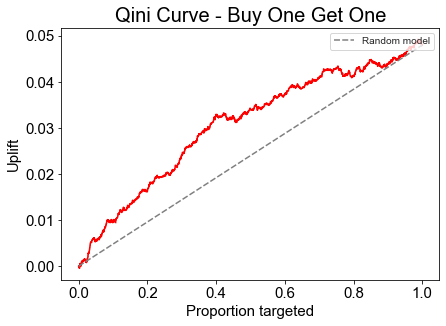

In [12]:
qini(bogo_uplift)
plt.title('Qini Curve - Buy One Get One',fontsize=20)